<a href="https://colab.research.google.com/github/OliDeane/Deep_SAGA/blob/master/Deep_SAGA_V2021_vGit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Before Running:**

Create a folder in Google drive named 'Gaze_Detection_System' and store the video being processed and the associated gaze data in that folder. Also in this folder should be the coco_labels.txt file, maskrcnn_predict.py and mask_rcnn_coco.h5. The folder should be made in myDrive so the path should look like this: myDrive > Gaze_Detection_System.

Name the video in the correct format (e.g. pp1_s1_City_vidA.mp4). Name the gaze data in the correct format (e.g. GD_pp1_s1_City_vidA). Bare in mind that both are case sensitive. 

There is an example video and gaze data in the shared google drive - use this to test that the system is working - (for this, insert 1 for the pp number input box, 1 for the session number box, 'City' for the environmnet type and A for the video box.

Also ensure that the GPU is activated for your Google Colab environmnet. Go to 'Runtime' > 'Change Runtime Type' > Select 'GPU' > 'Save'.

**After Running:**

When prompted insert the pp number, vid number, session number, environmnet type and date. 

The code will also ask whether you would like to check how the greenery detector is identifying green within the video. If it is the first time running the code for a given video, then it is advised that you respond 'yes' to this and follow the instructions at the 'greenery detection' section of this code.
**bold text**
You will also have to mount the google drive. When prompted, follow the provided link, proceeed to your google account and copy and paste the new link into the provided input box. 

Outputs:

1) List of what is being gazed upon for each frame.
2) Summary sheet informing on the total number of frames processed, the average number of persons and vehicles appearing in a frame and the average percentage of pixels within a frame that were tagged as green.
3) Graph visualising what is being gazed upon for each frame.
4) Heatmap displaying distribution of gaze





In [1]:
! git clone https://github.com/OliDeane/Deep_SAGA.git

Cloning into 'Deep_SAGA'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 68 (delta 24), reused 31 (delta 15), pack-reused 0
Unpacking objects: 100% (68/68), done.


In [2]:
!git config --global user.email "oliver.deane@gmail.com"
!git config --global user.name "OliDeane"

In [12]:
!git push origin master

fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
|# Connect to Github

# Mount the google drive
from google.colab import drive
drive.mount("/content/gdrive")

# Go to the project folder and clone the github repo into the project folder
cd gdrive/My Drive/Deep_SAGA
! git clone https://github.com/OliDeane/Deep_SAGA.git
cd Deep_SAGA/System_Code/

SyntaxError: ignored

In [1]:
# Import all the main packages

import pandas as pd
import numpy as np
import colorsys
import argparse
import imutils
import random
import cv2
import os
import time
from google.colab.patches import cv2_imshow
from google.colab import files
from PIL import Image, ImageDraw, ImageFont
from datetime import datetime
import io
import pandas as pd
import matplotlib.pyplot as plt
import h5py
if h5py.__version__ != '2.10.0":
  !pip install h5py==2.10.0


In [5]:
# Go to correct file location!
# !ls
# !cd Deep_SAGA/System_Code/


%cd Deep_SAGA/System_Code


/content/Deep_SAGA/System_Code


In [6]:
%tensorflow_version 1.x
import tensorflow as tf

#Check that tensorflow is running using the GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print(tf.__version__)

# Grab the MRCNN model from github
!pip install git+https://github.com/matterport/Mask_RCNN.git

#Import the mrcnn model and all necessary accompanying files
import mrcnn
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize

TensorFlow 1.x selected.
Found GPU at: /device:GPU:0
1.15.2
  Cloning https://github.com/matterport/Mask_RCNN.git to /tmp/pip-req-build-hc4ux6ki
  Running command git clone -q https://github.com/matterport/Mask_RCNN.git /tmp/pip-req-build-hc4ux6ki
  Created wheel for mask-rcnn: filename=mask_rcnn-2.1-cp37-none-any.whl size=56937 sha256=d9253064b876d0b2927a5d30e8e763afb4e28405ef468b5ac2210a1e0d1de207
  Stored in directory: /tmp/pip-ephem-wheel-cache-hja055vi/wheels/c2/db/78/1af79db27d80d68b0eb94d95fda90b8b2c2f6e8862b13d5d01
Successfully built mask-rcnn


Using TensorFlow backend.


In [ ]:
# # Define input and output files
# video_filename = "pp1_s1_City_vidA.mp4"
# gaze_filename = "GD_pp1_s1_City_vidA.csv"

# # Import the model and tensorflow, checking that it is running with the GPU
# from MRCNN_Functions import *
# %tensorflow_version 1.x
# import tensorflow as tf
# check_gpu()

# !pip install git+https://github.com/matterport/Mask_RCNN.git

# import mrcnn
# from mrcnn.config import Config
# from mrcnn import model as modellib
# from mrcnn import visualize



In [ ]:
#@title Filename Definition - IGNORE
# Define the names of the input and output files. 
 
# Test the Network with user input
# p_num = int(input("Participant Number: ")) # CHANGED FOR ROOM VIDEO
p_num = input("Participant Number: ")
vid_num = str(input("Video: "))
sesh_num = int(input("Participant Session Number: "))
environment = str(input("Environment (City, Nature): "))
date = str(input("Date (e.g. 27042020): "))
green_check = input("Do you want the code to stop and allow for a greenery check (yes or no): ")
 
# Define path to where all resources are stored in the dirive
path = r"/content/gdrive/My Drive/Gaze_Detection_System"
 
 
input_video_filename = "pp{}_s{}_{}_vid{}.mp4".format(p_num, sesh_num, environment, vid_num) #,date)   # 'pp4_vidA_s1_N_0308.mp4' # Name of video input
output_video_filename = "pp{}_vid{}_s{}_{}_{}.mp4".format(p_num, vid_num, sesh_num, environment, date)  # 'pp4_vidA_s1_N_0308_output.mp4' # Name of video output
 
gaze_filename = "GD_pp{}_s{}_{}_vid{}.csv".format(p_num, sesh_num, environment, vid_num) #, date)    # 'final_GD_pp4_vidA_s1_N_0308.csv' 
 
object_output_filename = "mrcnn_obscores_pp{}_vid{}_s{}_{}_{}.csv".format(p_num, vid_num, sesh_num, environment, date)         # "mrcnn_obscores_pp4_vidA_s1_N_0308.csv"
GPVscores_output_filename =  "mrcnn_GPVscores_pp{}_vid{}_s{}_{}_{}.csv".format(p_num, vid_num, sesh_num, environment, date)                          # "mrcnn_GPVscores_pp4_vidA_s1_N_0308.csv"
summary_scores_output_filename = "mrcnn_summary_scores_pp{}_vid{}_s{}_{}_{}.csv".format(p_num, vid_num, sesh_num, environment, date)                    # "mrcnn_summary_scores_pp4_vidA_s1_N_0308.csv"

In [ ]:
#@title Install tensorflow and model - can ignore
%tensorflow_version 1.x
import tensorflow as tf

#Check that tensorflow is running using the GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print(tf.__version__)

# Grab the MRCNN model from github
!pip install git+https://github.com/matterport/Mask_RCNN.git

#Import the mrcnn model and all necessary accompanying files
import mrcnn
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize


In [8]:
# load in class label names
def load_class_labels(path):
  # load the class label names, one label per line
  os.listdir(path)
  CLASS_NAMES = open(os.path.join(path,"coco_labels.txt")).read().strip().split("\n")

  # generate random (but visually distinct) colors for each class label
  # (thanks to Matterport Mask R-CNN for the method!)
  hsv = [(i / len(CLASS_NAMES), 1, 1.0) for i in range(len(CLASS_NAMES))]
  COLORS = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
  random.seed(42)
  random.shuffle(COLORS)

  return CLASS_NAMES, COLORS


class SimpleConfig():

	NAME = "coco_inference" 
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1
	NUM_CLASSES = 81

def configure_model(path, config, modellib):
  weights_path =os.path.join(path, "mask_rcnn_coco.h5") 

  # initialize the Mask R-CNN model for inference and then load the
  # weights
  print("[INFO] loading Mask R-CNN model...")
  model = modellib.MaskRCNN(mode="inference", config=config,
  model_dir=os.getcwd())
  model.load_weights(weights_path, by_name=True)





In [9]:
## Load in all the necessary files for the MRCNN and initialise the network  

# Get the class labels and associated colors
path = os.getcwd()
CLASS_NAMES, COLORS = load_class_labels(path)

# initialize the inference configuration
config = SimpleConfig()

model = configure_model(path, config, modellib)

[INFO] loading Mask R-CNN model...


AttributeError: ignored

In [ ]:

# Add our own class_names to the class names list
CLASS_NAMES.append('Background')
CLASS_NAMES.append('Greenery')
CLASS_NAMES.append('OOB')

We then load in the gaze coordinates and convert into a list of integers so they can be compared to the Mask RCNN's output object coordinates

In [ ]:
raw_gaze = open(os.path.join(path, gaze_filename)).read().strip().split("\n")

raw_gaze.pop(0) # remove the x and y
GX = [round(float(pair.split(",")[0])) for pair in raw_gaze]
GY = [round(float(pair.split(",")[1])) for pair in raw_gaze]

Load in the video footage and define where the ouput video will be saved to. We also check that the number of frames in the video matches the number of coordinates listed in the gaze data. If there are more frames than coordinates, then the eye tarcker glitched and missed some frames during recording. If this numebr is too high then the gaze coordinates will be out of sync with the mrcnn object coordinates. If the eye tracker did not drop too many (< 10) frames, then the analysis can go ahead. If not, then the data may have to be collected again. 

In [ ]:
vid_input = os.path.join(path, input_video_filename)
vid_output = os.path.join(path, output_video_filename)

#Initialise the video stream and pointer to output video file
vs = cv2.VideoCapture(vid_input)
writer = None

# Obtain the number of frames in the video

prop = cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() else cv2.CAP_PROP_FRAME_COUNT
total = int(vs.get(prop))
print("[INFO] {} total frames in video".format(total))


# Check that the number of frames in which the eye tracker failed to collect any data

dropped_frames = total - len(GX)

if dropped_frames > 0 and dropped_frames < 10:
  [GX.append(0) for i in range(0,dropped_frames)]
  [GY.append(0) for i in range(0,dropped_frames)]
  print('[INFO] The eye tracker dropped {} frames. {} 0s have been added to each gaze coordinate list.'.format(dropped_frames, dropped_frames))

elif dropped_frames > 10:
   raise Exception('The number of dropped frames is too high: {}'.format(dropped_frames))

else:
  print("[INFO] All good. The eye tracker didn't drop any frames.")

[INFO] 211 total frames in video
[INFO] All good. The eye tracker didn't drop any frames.


USER ACTIONA REQUIRED

If the greenery_check was sat to 'True' then the code will stop and present images of what the greenery system will output. 4 image pairs will be presented. The top image in the pair shows the original frame, the bottom image shows what the greenery mask identifies as green (white pixels = green pixels).Change the two key variables (Greenery_value_A and B) depending on whether the system is detecting too much green (e.g if detecting light/dark colours as green) or too little green. Once the greenery check is complete, change the greenery check value to FALSE and re-run the code (the ain for loop will not work if done after the greenery check without re-importing the video). Be sure to input the final greenery values when prompted in the next cell. 

If the greenery check is set to False, the following cell will still prompt the user to insert greenery values. Good default values are: 

Greenery_value_A = 50
Greenery_Value_B = 90

In [ ]:
if green_check == 'yes':

  # Alter the below two values until the greenery mask image is identifying greenery in the frame image at an optimum rate
  greenery_value_A = 80
  greenery_value_B = 90
  for frame_num in range(0, round(total/4)):
    grabbed, frame = vs.read()
    frame_list = [1, round((total/4)*0.25), round((total/4)*0.5), round((total/4)*0.75), round((total/4))]
    if frame_num in frame_list:
      hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
      test_gmask = cv2.inRange(hsv,(30, greenery_value_A, 20), (greenery_value_B, 255, 255) )
      cv2_imshow(frame)
      cv2.waitKey(0)
      cv2_imshow(test_gmask)

When prompted, insert the final greenery values. 

In [ ]:
greenery_value_A = int(input('Insert final greenery value for Value A here: '))
greenery_value_B = int(input('Insert final greenery value for Value B here: '))

Insert final greenery value for Value A here: 80
Insert final greenery value for Value B here: 90


Below we define the functions used in the main system for loop.

In [ ]:
def draw_mrcnn_output(frame, startX, startY, endX, endY, color, label, score):
  cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
  text = "{}: {:.3f}".format(label, score)
  y = startY - 10 if startY - 10 > 10 else startY + 10
  cv2.putText(frame, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX,
    0.6, color, 2)   

def apply_green_overlay(frame, gmask, greenery_score):
    overlay = frame.copy()
    grindex = np.where(gmask == 255) # Find the pixels that are green
    overlay[grindex[0][:],grindex[1][:],0] = 250 # Change these pixels in the overlay - make blue value high
    overlay[grindex[0][:],grindex[1][:],1] = 20 # Green value low
    overlay[grindex[0][:],grindex[1][:],2] = 20 # Red value low
    alpha = 0.6
    cv2.addWeighted(overlay, alpha, frame, 1-alpha, 0 , frame)

    if len(grindex[0][:]):
      temp_greenery_score = (len(grindex[0][:]) / (720*1280)) * 100
      greenery_score.append(temp_greenery_score) #  This stores the percentage of the given frame that was identified as green. 

    return greenery_score

 
def identify_inframe_objects(GY, GX, count, mask, inframe_gaze_checklist, confidence_list, inframe_object_loc_X,\
                          inframe_object_loc_Y, startX, startY):
 

  if GY[count] > 0 and GY[count] < 720 and GX[count] > 0 and GX[count] < 1280: # If the gaze fell within the headview camera's boundaries
    if mask[GY[count],GX[count]]: # == True:
      #label_winner = classID
      inframe_gaze_checklist.append(CLASS_NAMES[classID]) # inframe_gaze_checklist is the objects appearing in the given frame
      confidence_list.append(2)
      inframe_object_loc_X.append(startX)
      inframe_object_loc_Y.append(startY)

    else:
      #label_winner = 'Background'
      inframe_gaze_checklist.append(0)
      confidence_list.append(0)
      inframe_object_loc_X.append(0)
      inframe_object_loc_Y.append(0)
      
  else: # If gaze did not fall within the head view camera boundaries then add 'outofbounds' to the gazed_upon_object_list list
    label_winner = 'Out Of Bounds'
    inframe_gaze_checklist.append('OOB')
    confidence_list.append(0)
    inframe_object_loc_X.append(0)
    inframe_object_loc_Y.append(0)

  return inframe_gaze_checklist, confidence_list, inframe_object_loc_X, inframe_object_loc_Y


def get_gazed_upon_object(inframe_gaze_checklist, confidence_list, inframe_object_loc_X, inframe_object_loc_Y, gazed_upon_object_list, confidence, gmask):

  gazed_upon_index = [i for i, e in enumerate(inframe_gaze_checklist) if e != 0] # gazed_upon_index is the index of the winning classID (if there is one)


  if len(gazed_upon_index) > 0: # If there is a single winning object then add the winner to the gazed_upon_object_list list    
    new_champ = inframe_gaze_checklist[gazed_upon_index[0]]  
    current_startX = inframe_object_loc_X[gazed_upon_index[0]] # This defines the current location of the gazed upon object
    current_startY = inframe_object_loc_Y[gazed_upon_index[0]]
    
    if new_champ == 59: # if it's a potted plant, then mark as green
      gazed_upon_object_list.append('Greenery')
    else: # If the recognised object is not a potted plant, then add that classID to the gazed_upon_object_list list
      gazed_upon_object_list.append(new_champ)

  elif len(gazed_upon_index) == 0: # If no winning object was found, then check if green is being looked at
    
    if GY[count] > 0 and GY[count] < 720 and GX[count] > 0 and GX[count] < 1280: # If the gaze fell within the headview camera's boundaries 
      if gmask[GY[count],GX[count]] == 255: # If the gaze coords falls on a green area (The mask is flipped - so is GY,GX)
        new_champ = 'Greenery'
        gazed_upon_object_list.append('Greenery') # 82 is greenery
        confidence.append(0)
        
      elif gmask[GY[count],GX[count]] == 0:
        new_champ = 'Background'
        gazed_upon_object_list.append('Background')
        confidence.append(0)

    else:
      new_champ = 'OOB'

  return gazed_upon_object_list, confidence, new_champ


def overlay_label(CLASS_NAMES, new_champ, frame):
  # Draw the Text on top
  font = cv2.FONT_HERSHEY_SIMPLEX 
  org = (50, 50)       
  fontScale = 2      
  color = (0, 0, 255)  # Red     
  thickness = 2      
  # winner_label = CLASS_NAMES[new_champ] # text to draw
  image = cv2.putText(frame, new_champ, org, font,  
                    fontScale, color, thickness, cv2.LINE_AA) 
  return image


def overlay_gaze_cursor(GX, GY, count, frame):
  center_coordinates = (GX[count], GY[count]) 
  radius = 30 
  color = (0, 0, 255) 
  thickness = -1
    
  # Using cv2.circle() method 
  # Draw a circle of red color of thickness -1 px 
  image = cv2.circle(frame, center_coordinates, radius, color, thickness) 
  return image

def print_user_info(count, total):
  if count == 8:
    elap = (end - start)
    print("[INFO] single frame took {:.4f} seconds".format(elap))
    print("[INFO] estimated total time to finish: {:.4f}".format((elap * (total/4))))    
  elif count == round(total/8): #round(quartal/2):
    print("[INFO] Halfway!")


Below are the functions for grphing the data. First for the graph showing what is gazed upon for each frame of footage, then for the heatmap

In [ ]:
# Generate the graphs
# First normalise data to make it a normal list
def normalise_data(data):
  data_set_edit = []
  for i in range(0,len(data)):
    data_set_edit.append(data[i])# [0])
  return data_set_edit

def prepare_for_graphing(data_set, unique_cats): # Prepare data for graphing
  unique_cats_2 = unique_cats
  data_set_2 = data_set
  graph_list = []
  for category in unique_cats:
    graph_list.append([i for i, e in enumerate(data_set) if e == category])


  GU_object_graphing_dict = {}
  for i in range(0,len(unique_cats)):
    GU_object_graphing_dict.update( {unique_cats[i]: get_broken_bar_list(graph_list[i])} )
    
  return GU_object_graphing_dict

# Function to get final list for the broken bar chart
def get_broken_bar_list(gaze_object_list):
  output_list = []
  for i in gaze_object_list:
    output_list.append((i,1))

  return output_list

def generate_graph(GU_object_graphing_dict, unique_cats, system_data, ax):

  y_tick_labels = [] # For the Ytick Labels
  iterations = []

  color_list = ['purple', 'olive', 'brown', 'cyan', 'pink']*15
  color_dict = {}
  count = 0
  # Get colour for the graphing
  for i in unique_cats:
    if i == 'Greenery':
      color_dict.update( {i: 'green'} )
    elif i == 'Person':
      color_dict.update( {i:'red'})
    elif i == 'Vehicle':
      color_dict.update( {i:'orange'})
    elif i == 'Background':
      color_dict.update( {i:'blue'})
    else:
      color_dict.update( {i: color_list[count]} )
    count += 1


  count = 0
  for i in GU_object_graphing_dict:
    count += 1
    ax.broken_barh(GU_object_graphing_dict[i], ((count*5), 5), facecolors='tab:{}'.format(color_dict[i])) 

    y_tick_labels.append(count*5+2.5)
    iterations.append(count*5)


  ax.set_ylim(5, len(unique_cats)*5+5)
  ax.set_xlim(0, len(system_data))
  ax.set_xlabel('Frame Number')
  ax.set_ylabel('Gazed Upon Object')

  # if title:
  #   ax.set_title('Objects Gazed At For Each Frame Of Footage As Generated By The Novel System and The Human Coder'.format(coder_identity))

  ax.set_yticks(y_tick_labels)
  ax.set_yticklabels(unique_cats)
  ax.grid(False)

  iterations = [10,15,20,25,30] # Add in lines around bars
  for i in iterations:
    ax.axhline(y=i,linewidth=1, color='gray', alpha = 0.3)

  return ax


In [ ]:
# Define the lists that will be built in the following while loop
gazed_upon_object_list = [] # List of objects that were being looked at for each frame
confidence = [] # List saying whether the gaze is in the mask/just in the box
green_list = []
greenery_score = []
persons_in_video = []
vehicles_in_video = []


"""
Begin the processing for loop. This finds the coordinates and labels for each object and computes a greenery mask. 
It compares the gaze coordinates with the object coordinates/greenery mask to determine what is being looked at for each frame.
The final frame-by-frame list is stored in the 'gazed_upon_object_list' and the 'average_persons_per_frame' and 
'average_vehicles_per_frame' are an show the average number of persons/vehicles in each frame. The average_greenery_score
is the average percentage of pixels in each frame that were tagged as green.
"""
now = datetime.now() #Print the current time for timing checks
current_time = now.strftime("%H:%M:%S")
print('[INFO] Current Time =', current_time)

for count in range(0, total):
  
  start = time.time()
  # read the next frame from the file
  (grabbed, frame) = vs.read()
  
  if (count % 4) == 0: # We only process 1 in 4 frames (to save time). Delete this if statement to process all frames
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    gmask = cv2.inRange(hsv,(30, greenery_value_A, 20), (greenery_value_B, 255, 255) )
    r = model.detect([frame], verbose=0)[0] # verbose tells us whether we want to see the output or not

    inframe_gaze_checklist = []
    inframe_labels = []
    confidence_list = []
    inframe_object_loc_X = []
    inframe_object_loc_Y = []
    persons_in_frame = 0
    vehicles_in_frame = 0

    for object in range(0, r["rois"].shape[0]): # Loop over class labels
      # extract the class ID and mask for the current detection, then
      # grab the color to visualize the mask (in BGR format)
      classID = r["class_ids"][object]
      mask = r["masks"][:, :, object]
      color = COLORS[classID][::-1]

      # visualize the pixel-wise mask of the object
      frame = visualize.apply_mask(frame, mask, color, alpha=0.5)

      # extract the bounding box information, class ID, label, predicted
      # probability, and visualization color
      (startY, startX, endY, endX) = r["rois"][object]
      classID = r["class_ids"][object]
      label = CLASS_NAMES[classID]
      score = r["scores"][object]
      color = [int(c) for c in np.array(COLORS[classID]) * 255]
      inframe_labels.append(classID)

      if classID == 1: # If it's a person, add one to the person count list
        persons_in_frame += 1
      elif classID == 3 or classID == 4 or classID == 6 or classID == 8: # If object is a car, bus, motorbike or truck, then add that to the list
        vehicles_in_frame +=1

      draw_mrcnn_output(frame, startX, startY, endX, endY, color, label, score)

      # Find labels and coords for all objects in a frame
      inframe_gaze_checklist, confidence_list, inframe_object_loc_X, inframe_object_loc_Y = identify_inframe_objects(GY, GX, count, mask, inframe_gaze_checklist, confidence_list, inframe_object_loc_X,\
                          inframe_object_loc_Y, startX, startY)

      # Now combine the frames together to produce the output video     
      if writer is None:
        fourcc = cv2.VideoWriter_fourcc(*"MJPG") # Initialises the video writer
        writer = cv2.VideoWriter(vid_output, fourcc, 10,
          (frame.shape[1], frame.shape[0]), True) # Vid output is the path to the drive folder where the output video will go  
    
    greenery_score = apply_green_overlay(frame, gmask, greenery_score) # Find percentage of frame that is green greenery_score and apply greenery mask to the frame
    persons_in_video.append(persons_in_frame) # Add the v and p counts so that index 1 gives the number of people/vehicles in the first frame, same for index 2 etc....
    vehicles_in_video.append(vehicles_in_frame)
    
    
    gazed_upon_index = [i for i, e in enumerate(inframe_gaze_checklist) if e != 0] # gazed_upon_index is the index of the winning classID (if there is one)

    gazed_upon_object_list, confidence, new_champ = get_gazed_upon_object(inframe_gaze_checklist, confidence_list, inframe_object_loc_X, inframe_object_loc_Y, gazed_upon_object_list, confidence, gmask)

    overlay_label(CLASS_NAMES, new_champ, frame) # !!!!!! Change to not being == to image
    overlay_gaze_cursor(GX, GY, count, frame)

    end = time.time()
    writer.write(frame)

  print_user_info(count, total)

# release the file pointers
print("[INFO] cleaning up...")
writer.release()
vs.release()

 

[INFO] Current Time = 12:56:31

[INFO] single frame took 0.5438 seconds
[INFO] estimated total time to finish: 28.6858
[INFO] Halfway!
[INFO] cleaning up...


Below downloads the final list showing which object is being gazed upon for each frame of footage

In [ ]:
average_persons_per_frame = (sum(persons_in_video)/len(persons_in_video))
average_vehicles_per_frame = (sum(vehicles_in_video)/len(vehicles_in_video))
average_greenery_score = (sum(greenery_score)/len(greenery_score))
key_features_scores_list = [int(round(total/4)), average_persons_per_frame, average_vehicles_per_frame, average_greenery_score]

key_feature_scores_df = pd.DataFrame(columns=['Feature', 'Score'])
key_feature_scores_df['Feature'] = ['Num of processed frames','Persons per frame', 'Vehicles per frame', 'Greenery per frame (% of pixels)']
key_feature_scores_df['Score'] = key_features_scores_list

key_feature_scores_df.to_csv(summary_scores_output_filename, index = False)
files.download(summary_scores_output_filename)

GU_list_df = pd.DataFrame(gazed_upon_object_list) 
GU_list_df.to_csv(object_output_filename, index = False)
files.download(object_output_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

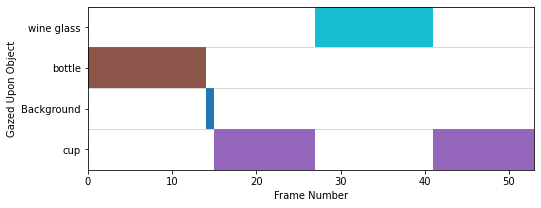

In [ ]:

normal_system_data = normalise_data(gazed_upon_object_list)
system_unique_categories = list(set(normal_system_data)) # Lists all unique objects appearing in GU list
GU_object_graphing_dict = prepare_for_graphing(normal_system_data, system_unique_categories)

#Initiate Graph
fig, plotter = plt.subplots(1, figsize=(8,3), sharex = True, gridspec_kw = {'hspace' : 0.05})
plt.rc('font', family='sans serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

ax = generate_graph(GU_object_graphing_dict, system_unique_categories, gazed_upon_object_list, plotter)

fig.savefig('Comparison_Fig_Video_{}.svg'.format(date), format='svg', dpi=1200) # , dpi=1200)
files.download('Comparison_Fig_Video_{}.svg'.format(date))

Below is old processing stuff. Can ignore for now. The first cell is a working basic version of the system. Above is this version add a feature that overlays the currently gazed upon item label on top. Below writes every 4 frames, so is quicker to complete. 

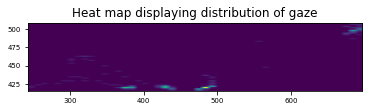

In [ ]:
# It's deleting as we go so the legnth of spareGX is getting smaller so will eventually be out of range
heatmap, xedges, yedges = np.histogram2d(GX, GY, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

#plt.clf()
hetmap_fig = plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.title('Heat map displaying distribution of gaze')

plt.savefig('heatmap_fig.pdf')
files.download('heatmap_fig.pdf')

plt.show()